# Topic Modeling + Plots for Paper

## Setup

In [25]:
import pandas as pd
from datetime import date
from pathlib import Path
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.ticker as mtick
import random
import numpy as np
from scipy.stats import entropy
import seaborn as sns
import opinionated  # noqa
import matplotlib.pyplot as plt

plt.style.use("opinionated_rc")

CITY_SHORTCODE_NAME_LUT = {
    "AA": "Ann Arbor, MI",
    "RO": "Royal Oak, MI",
    "AP": "Alpena, MI",
    "CS": "Cedar Springs, MI",
    "GA": "Garden City, MI",
    "IN": "Inkster, MI",
    "JS": "Jackson, MI",
    "LS": "Lansing, MI",
    "LV": "Lathrup Village, MI",
    "LN": "Livonia, MI",
    "MH": "Madison Heights, MI",
    "MT": "Manistee, MI",
    "MP": "Memphis, MI",
    "MC": "Mt Clemens, MI",
    "PE": "Perry, MI",
    "PR": "Pleasant Ridge, MI",
    "RM": "Richmond, VA",
    "SL": "Saline, , MI",
    "SC": "St Clair, MI",
    "SH": "Sterling Heights, MI",
    "WT": "Williamston, MI",
    "SEA": "Seattle, WA",
    "OAK": "Oakland, CA",
}

CITIES_OF_INTEREST = [
    "AA",
    "RO",
    "JS",
    "LS",
    "SEA",
    "OAK",
]

ANNOTATIONS_DIR = Path("../data/annotated-for-modeling/").resolve()

In [26]:
# Get the bold color map values
# PALETTE_BOLD = cmaps.bold._colors
COLORBREWER_PALETTE = np.array([
    [27, 158, 119],  # green
    [217, 95, 2],  # orange
    [117, 112, 179],  # purple
])
COLORBREWER_PALETTE = COLORBREWER_PALETTE / 255
sns.set_palette(COLORBREWER_PALETTE)

## Data Cleaning and Subsetting

In [27]:
# Store all data to single object
data_dfs = []


def split_short_name_to_city_and_date(short_name: str) -> tuple[str, date]:
    # Split the short name into city and date
    short_code_and_date_parts = short_name.split("_")

    # Short code is the first part
    short_code = short_code_and_date_parts[0]

    # Date is the rest in month day two-digit-year format
    event_date = date(
        year=int("20" + short_code_and_date_parts[-1]),
        month=int(short_code_and_date_parts[1]),
        day=int(short_code_and_date_parts[2]),
    )

    return short_code, event_date


# Read all data
for filepath in ANNOTATIONS_DIR.glob("*.csv"):
    # Read the comment data
    df = pd.read_csv(filepath)

    # Lowercase all columns
    df.columns = df.columns.str.lower()

    # Remove any spaces from column names and replace with "_"
    df.columns = df.columns.str.replace(" ", "_")

    # Split the "name" column into "city_short_code" and "date"
    df["city_short_code"], df["date"] = zip(
        *df["name"].apply(split_short_name_to_city_and_date),
        strict=True,
    )

    # Add the city name
    df["city_name"] = df["city_short_code"].map(CITY_SHORTCODE_NAME_LUT)

    # Add a year-month column
    df["year_month"] = df["date"].apply(lambda x: x.replace(day=1))

    # Using the filename, mark if this was a "training" or "inferred" dataset
    df["dataset_portion"] = filepath.stem.split("_")[-1]

    # Add the truth data to the list
    data_dfs.append(df)

# Concatenate all training data
full_data = pd.concat(data_dfs)

# Replace dataset portion with standard names
full_data["dataset_portion"] = full_data["dataset_portion"].replace(
    {"truth": "train", "pred": "inferred", "val": "test"}
)

# Subset the data to only the columns we care about
full_data = full_data[
    [
        "city_short_code",
        "city_name",
        "date",
        "year_month",
        "dataset_portion",
        "meeting_section",
        "speaker_role",
        "start",
        "end",
        "text",
    ]
]

full_data.sample(3)

,city_short_code,city_name,date,year_month,dataset_portion,meeting_section,speaker_role,start,end,text
387,SEA,"Seattle, WA",2021-08-02,2021-08-01,test,Public Comment,Commenter,1722.0,1781.0,"Hello, my name is Cassandra Oaks and I am a me..."
1695,SEA,"Seattle, WA",2021-07-12,2021-07-01,train,Other,Other,3520.0,3531.0,"Aye. Nine in favor, none opposed. The bill pas..."
2046,RO,"Royal Oak, MI",2023-04-24,2023-04-01,train,Other,Other,7347.0,7354.0,The Petitioner is reconsidering their proposal...


In [35]:
# Filter to only the cities of interest
full_data = full_data[full_data["city_short_code"].isin(CITIES_OF_INTEREST)]

# Filter out government comments and only use public comment not hearing
meeting_comments = full_data[
    (full_data["meeting_section"] == "Public Comment")
    & (full_data["speaker_role"] == "Commenter")
]

meeting_comments.shape

# Order data by city population and date
city_order = [
    "Seattle, WA",  # 737,015
    "Oakland, CA",  # 440,646
    "Ann Arbor, MI",  # 123,851
    "Lansing, MI",  # 112,644
    "Royal Oak, MI",  # 58,211
    "Jackson, MI",  # 31,309
]

## Comments by City by Dataset Portion

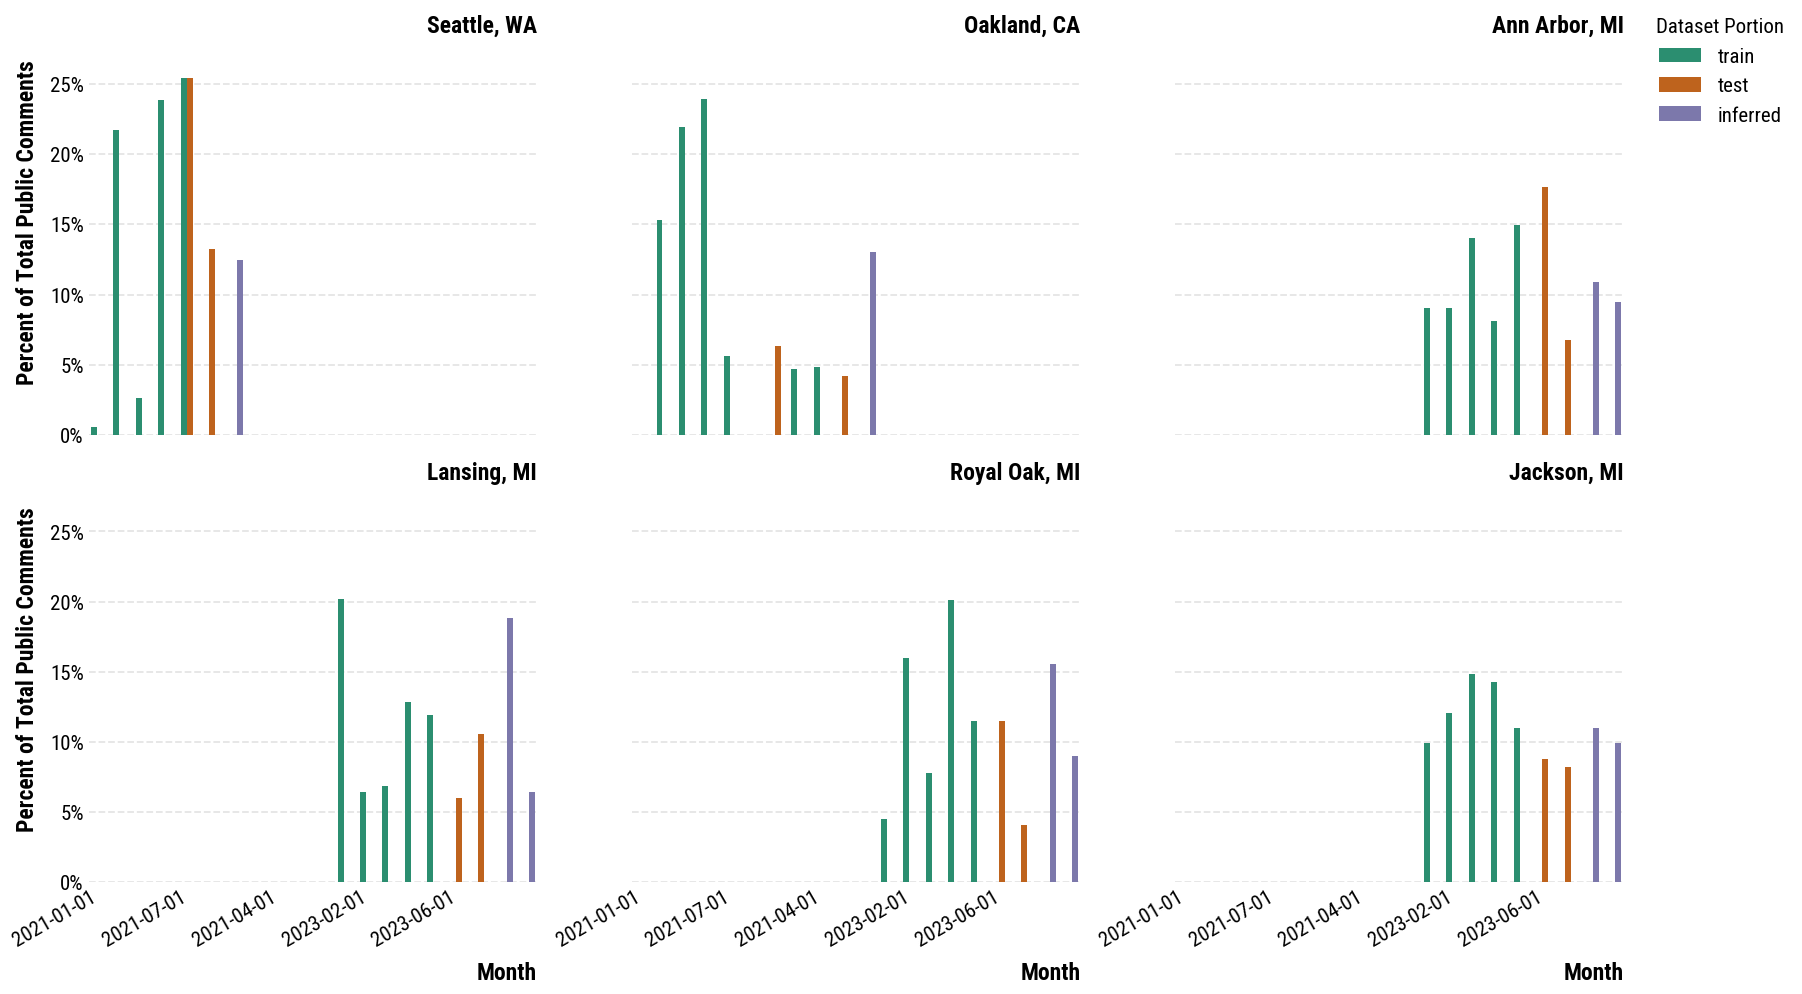

In [66]:
# Get the percent of comments by city (per month)
# i.e. how much of the training or inferred data comes from this month

# First get the total number of comments per city
city_comment_counts = meeting_comments["city_name"].value_counts()

# Get the total number of comments per city per month
city_month_comment_counts = meeting_comments.groupby(["city_name", "year_month"]).size()

# Iter rows and calculate the percent
percent_comments_list = []
for _, row in meeting_comments.iterrows():
    this_city_total_comments = city_comment_counts[row["city_name"]]
    this_city_month_total_comments = city_month_comment_counts[
        row["city_name"], row["year_month"]
    ]
    percent = (this_city_month_total_comments / this_city_total_comments) * 100
    percent_comments_list.append(
        {
            "city_name": row["city_name"],
            "year_month": row["year_month"],
            "percent_of_comments": percent,
            "Dataset Portion": row["dataset_portion"],
        }
    )

# Convert to a DataFrame
processed_percent_comments = pd.DataFrame(percent_comments_list)

# For each city, order the months by date
city_dfs = []
for city in city_order:
    city_df = processed_percent_comments[processed_percent_comments["city_name"] == city]
    city_df = city_df.sort_values("year_month", ascending=True)
    city_dfs.append(city_df)

# Concatenate the city dataframes
percent_comments_df = pd.concat(city_dfs)

# Col by city
g = sns.catplot(
    data=percent_comments_df,
    x="year_month",
    y="percent_of_comments",
    hue="Dataset Portion",
    col="city_name",
    col_wrap=3,
    kind="bar",
)

# Update the x-axis, and y-axis labels
g.set_axis_labels("Month", "Percent of Total Public Comments")
g.figure.autofmt_xdate()
g.set_titles("")
g.set_titles("{col_name}", loc="right")

# For each ax in the figure, set the x-axis locator to max 8 ticks
for ax in g.axes:
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Tight Layout
g.figure.tight_layout()

# Move the legend outside and to the right of the plot
sns.move_legend(g, loc="upper right", bbox_to_anchor=(1.1, 1))

## Topic Modeling

In [ ]:
# Set random state
random.seed(0)
np.random.seed(0)

# Init topic model and pipeline components
cluster_model = MiniBatchKMeans(n_clusters=30, random_state=0)
vectorizer_model = TfidfVectorizer(
    stop_words="english", max_df=30, min_df=3, lowercase=True
)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)
umap_model = PCA(n_components=10)

topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=cluster_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
)

In [ ]:
# Fit transform all data
topics, _ = topic_model.fit_transform(meeting_comments.text)

# Store topics in the dataframe
meeting_comments["topic_id"] = topics

In [ ]:
# Get topic info and manually write topic names
topic_info = topic_model.get_topic_info()

# Print each topic and their representative docs
for _, row in topic_info.iterrows():
    print(f"Topic Id: {row['Topic']}")
    print(f"Short representation: {row['Representation']}")
    for doc in row["Representative_Docs"][:5]:
        print(f"\tExample Doc: {doc}")

    print("\n" + "=" * 80 + "\n")

In [ ]:
# Create topic_id to topic_name mapping
topic_id_to_name_lut = {
    0: "Police Reform",
    1: "Undefined",
    2: "Housing and Homelessness",  # Eviction and renters rights
    3: "Arts and Programs",
    4: "Capital Investment",  # investment in a basketball coliseum
    5: "Israel-Palistine",
    6: "Undefined",
    7: "Budget and Finance",  # Pandemic recovery
    8: "Police Reform",  # Oak
    9: "Police Reform",  # Sea
    10: "Community Events",
    11: "Transportation and Infrastructure",
    12: "Planning and Zoning",
    13: "Transportation and Infrastructure",
    14: "Undefined",
    15: "Undefined",
    16: "Budget and Finance",
    17: "Public Services",  # Disability Services and Libraries?
    18: "Ethics and Accountability",
    19: "Utilities",
    20: "Police and Public Safety",
    21: "Transportation and Infrastructure",
    22: "Housing and Homelessness",
    23: "Housing and Homelessness",  # Eviction and renters rights
    24: "Housing and Homelessness",  # Fair chance housing
    25: "Budget and Finance",
    26: "Undefined",
    27: "Police Reform",  # Non-police emergency response
    28: "Public Services",
    29: "Housing and Homelessness",
}

# Map the topic names to the dataframe
meeting_comments["topic_name"] = meeting_comments["topic_id"].map(topic_id_to_name_lut)
meeting_comments.topic_name.value_counts()

In [ ]:
# Filter out all undefined topics
plotting_comments = meeting_comments[meeting_comments["topic_name"] != "Undefined"]

In [ ]:
# Create topic name and city count dataframe
topic_city_counts = (
    plotting_comments.groupby(["city_name", "topic_name"])
    .size()
    .reset_index(name="comment_count")
)

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city_name")[
    "comment_count"
].transform(lambda x: x / x.sum())

### Percent of Comments by Topic

In [ ]:
# Keep this version of "all of the data"
# For the next two versions of the heatmap,
# fit the topic model on the training and valid set and apply on the inferred set

# Add one version of the heatmap that uses the "inferred" with the true comments
# Add one version of the heatmap that uses the "inferred" with the inferred comments
# Ignore the "Commenter" Speaker Role check for the "inferred" inferred data

# Heatmap of topic percentage per month per city
sns.heatmap(
    data=topic_city_counts.pivot(
        index="city_name", columns="topic_name", values="comment_pct"
    ),
    annot=True,
    fmt=".1f",
)
_ = plt.xticks(rotation=45, ha="right")

## Safety Checks on Model

In [ ]:
# LM plot with F1 of model + number of comments
city_name_f1_lut = {
    "Ann Arbor": 0.854,
    "Royal Oak": 0.781,
    "Jackson": 0.789,
    "Lansing": 0.627,
    "Seattle": 0.957,
    "Oakland": 0.719,
}

city_name_k_alpha_lut = {
    "Ann Arbor": 0.918,
    "Royal Oak": 0.931,
    "Jackson": 0.876,
    "Lansing": 0.953,
    "Seattle": 0.982,
    "Oakland": 0.900,
}

# Create dataframe of city_name, f1, comment_count, and entropy(topic_percents)
city_f1_entropy_df = []
for city_name, city_df in topic_city_counts.groupby("city_name"):
    if city_name not in city_name_f1_lut:
        continue

    # Get the f1
    f1 = city_name_f1_lut[city_name]
    k_alpha = city_name_k_alpha_lut[city_name]

    # Get the comment count
    comment_count = city_df["comment_count"].sum()

    # Get the entropy
    topic_percents = city_df["comment_pct"].values
    entropy_val = entropy(topic_percents)

    city_f1_entropy_df.append(
        {
            "city_name": city_name,
            "model_f1": f1,
            "k_alpha": k_alpha,
            "comment_count": comment_count,
            "topic_entropy": entropy_val,
        }
    )

city_f1_entropy_df = pd.DataFrame(city_f1_entropy_df)
city_f1_entropy_df

### Model F1 by Number of Comments

In [ ]:
# LM plot with F1 of model + number of comments
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="comment_count",
    y="model_f1",
    # hue="city_name",
)

### Model F1 by Entropy of Topic Distribution

In [ ]:
# LM plot with F1 and entropy
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="topic_entropy",
    y="model_f1",
    # hue="city_name",
)

In [ ]:
# LM plot with F1 and entropy
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="k_alpha",
    y="model_f1",
    # hue="city_name",
)

In [ ]:
# LM plot with F1 and entropy
_ = sns.lmplot(
    data=city_f1_entropy_df,
    x="k_alpha",
    y="topic_entropy",
    # hue="city_name",
)